# Day 27: Scaling Deep Dive + Log Transforms (Type B)

## Foundation Drilling:
**Dict Comprehension**

In [1]:
# Dict comprehension (new pattern from Week 3 doc)
# Basic pattern
# {key_expr: value_expr for item in iterable}

# Real example
prices = {'apple': 1.0, 'banana': 0.5, 'orange': 0.75}
doubled = {fruit: price * 2 for fruit, price in prices.items()}
print(doubled)
# Translation: "Build dict by transforming each key-value pair"

# Task: Create dict mapping column names to their data types
# {col: str(df[col].dtype) for col in df.columns}


{'apple': 2.0, 'banana': 1.0, 'orange': 1.5}


In [2]:
import pandas as pd
df = pd.DataFrame({"Names": ["Dad", "Delta", "Brooke", "Clebo", "Liam", "Henry"], "Ages": [42, 21, 20, 16, 14, 11],
      "Gender": ["Boy", "Girl", "Girl", "Boy", "Boy", "Boy"]})
mapped_dict = {col: str(df[col].dtype) for col in df.columns}

print(df)
print(f"\nMapped Dict:\n{mapped_dict}")

    Names  Ages Gender
0     Dad    42    Boy
1   Delta    21   Girl
2  Brooke    20   Girl
3   Clebo    16    Boy
4    Liam    14    Boy
5   Henry    11    Boy

Mapped Dict:
{'Names': 'object', 'Ages': 'int64', 'Gender': 'object'}


In [3]:
unique_counts = {col: df[col].nunique() for col in df.columns}

first_values = {col: df[col].iloc[0] for col in df.columns}

numeric_only = {col: str(df[col].dtype) for col in df.columns if df[col].dtype != 'object'}

print(unique_counts)
print(f"\n{first_values}\n")
print(numeric_only)

{'Names': 6, 'Ages': 6, 'Gender': 2}

{'Names': 'Dad', 'Ages': np.int64(42), 'Gender': 'Boy'}

{'Ages': 'int64'}


In [6]:
missing_val_count = {col: int(df[col].isna().sum()) for col in df.columns}
print(missing_val_count)

{'Names': 0, 'Ages': 0, 'Gender': 0}


## Block 1: Video Learning - Scaling and Transforms
**Goal:** Build intuition for WHY we scale and transform, not just HOW.

**Resource 1:** StatQuest — "StatQuest: Fitting a Line to Data (Linear Regression)"

- Link: https://www.youtube.com/watch?v=PaFPbb66DxQ
- Why this resource: Refresher on what linear regression is actually doing (coefficients, residuals)
- Focus on: How do feature magnitudes affect coefficient interpretation?

**Resource 2:** StatQuest — "Logs (Logarithms)"

- Link: https://www.youtube.com/watch?v=VSi0Z04fWj0
- Why this resource: Addresses your Day 25 gap on log transform intuition
- Focus on:
    - What does log(x) actually DO to a number?
    - Why does log "compress" large values more than small ones?
    - When is log transform appropriate?

**Resource 3 (Optional):** StatQuest — "Regularization Part 1: Ridge Regression"

- Link: https://www.youtube.com/watch?v=Q81RR3yKn30
- Why this resource: Regularization requires scaled features — connects scaling to next week's content
- Focus on: Why does Ridge need features on same scale?

## BLOCK 2: READING — Preprocessing Deep Dive (40%)

**Goal:** Understand scaling workflow and when each method applies.

**Resource:** Scikit-Learn User Guide — Preprocessing Data

- Link: https://scikit-learn.org/stable/modules/preprocessing.html
- Sections to focus on:
    - 6.3.1 Standardization (StandardScaler)
    - 6.3.2 Scaling to a range (MinMaxScaler)
    - Skip: Sparse data sections (not relevant yet)

**Focus questions while reading:**

1. What's the formula for StandardScaler? What do the output values represent?
2. When would MinMaxScaler be preferred over StandardScaler?
3. What happens if you fit scaler on test data? (data leakage)

**Secondary Reading:** Practical Statistics for Data Scientists

- Section on data transformations (log, Box-Cox)
- Focus on: When do transformations help linear models?

## BLOCK 3: NOTE-TAKING — Synthesize (20%)

**Create notes answering these questions:**

### Scaling Notes

1. **StandardScaler**
    - Formula: (in your own words) Subtract mean, divide by standard deviation → centers to mean=0, scales to std=1;
    - Translation: "Take each value, subtract the average, divide by how spread out the data is. Now all features centered at 0 with same spread."
    - Output range: depends on data; Most values between -3 and +3 (for normal-ish data), but technically unbounded (outliers can be -5, +10, etc.)
    - Use when: anytime there is 1 or more features that are numerically on a much different scale than the rest of the data
    - Sensitive to outliers? (yes/no, why) yes; Outliers pull the mean and inflate std → affects the scaling formula
2. **MinMaxScaler**
    - Formula: (in your own words) Formula: (x - min) / (max - min) → squashes to 0-1 range; 0 = original minimum value, 1 = original maximum value
    - Output range: typically 0-1 but can be set manually
    - Translation: "Find the smallest and largest values. Map smallest to 0, largest to 1, everything else proportionally in between."
    - Use when:
    - When algorithm needs bounded range (0-1), like neural networks with sigmoid
    - When StandardScaler isn't appropriate (non-normal distribution)
    - NOT because it handles outliers better (it doesn't)
    - Sensitive to outliers? (yes/no, why) YES; Uses min/max values directly. One extreme outlier stretches the range.
3. **The Data Leakage Trap**
    - What's wrong with: `scaler.fit(X)` before train/test split? It gives incorrect assessment of model's ability to analyze new/unseen data
    - Correct order:
    - 1. Split data first: train_test_split(X, y)
      2. Fit scaler on train only: scaler.fit(X_train) ← learns mean/std from train
      3. Transform train: X_train_scaled = scaler.transform(X_train) ← applies learned parameters
      4. Transform test (no fit!): X_test_scaled = scaler.transform(X_test) ← applies SAME parameters from train
4. **Which Algorithms Need Scaling?**
    - NEED scaling:
    - 1. Distance-based: KNN, SVM (distance metrics sensitive to feature magnitude)
      2. Gradient descent: Linear Regression, Logistic Regression, Neural Networks (gradient descent converges faster with scaled features)
      3. Regularized models: Ridge, Lasso (penalties compare coefficients — need comparable scales)
    
    - DON'T need scaling:
    - 1. Tree-based: Decision Trees, Random Forest, XGBoost (use splits, not distances)
      2. Naive Bayes: (probability-based, not magnitude-sensitive)

    - Why it matters:
    - 1. Without scaling: Feature with range [0-10000] dominates feature with range [0-1]
      2. With scaling: All features contribute equally to distance/gradient calculations

### Log Transform Notes

1. **What log does mathematically** (assumes working with Common Log, BASE 10)
    - log(10) = asks "10 to what power equals 10?" answer is 1
    - log(100) = asks "10 to what power equals 100?" answer is 2
    - log(1000) = asks "10 to what power equals 1000?" answer is 3
    - Pattern observed: for powers of 10, the log is simply a count of the zeros
2. **Why log helps skewed data**
    - Before log: large outliers dominate
    - After log: compressed range, more symmetric
    - Draw rough sketch of right-skewed distribution → after log
3. **When to use log transform**
    - Good for:
    - 1. Right-skewed distributions (long tail to the right)
      2. Data spanning orders of magnitude (prices: $10 to $10,000,000)
      3. Examples: income, population, website traffic, property values
    - Bad for:
    - 1. Zero or negative values (log(0) = undefined, log(-5) = undefined)
      2. Normal distributions (already symmetric, log makes it left-skewed)
      3. Left-skewed distributions (log makes it worse)
    - In sklearn: `np.log1p(x)` (why 1p?)
    - 1p = "1 plus"
    - Formula: log1p(x) = log(x + 1)
    - Why: Handles zeros!
    - log(0) = undefined (breaks)
    - log1p(0) = log(0 + 1) = log(1) = 0 (works!)
    - Translation: "Add 1 first, then take log. Shifts everything slightly so zeros become valid."

## BLOCK 4: LIGHT CODING (10% - Optional)

**Only if energy allows — no pressure on Type B.**

**Quick visualization of log transform effect:**

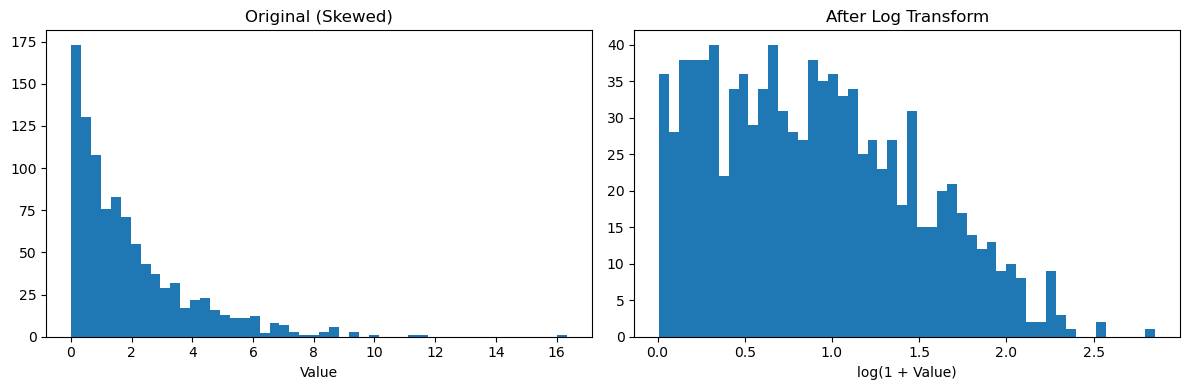

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Create skewed data
np.random.seed(42)
skewed_data = np.random.exponential(scale=2, size=1000)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(skewed_data, bins=50)
axes[0].set_title('Original (Skewed)')
axes[0].set_xlabel('Value')

axes[1].hist(np.log1p(skewed_data), bins=50)
axes[1].set_title('After Log Transform')
axes[1].set_xlabel('log(1 + Value)')

plt.tight_layout()
plt.show()


In [8]:
# List comprehension with condition
# Pattern: [expr for item in iterable if condition]

# reduced = [f for f in feature_cols if f not in ['Population', 'AveOccup']]

# Translation: "Keep only features NOT in the removal list"

# Set difference
# Pattern: set(A) - set(B)

# removed = set(feature_cols) - set(reduced_features)

# Translation: "What's in A that's not in B?"

# Nested loop for pairwise comparison
# Pattern: for i in range(len(x)): for j in range(i+1, len(x))
# Translation: "Compare each pair exactly once (no duplicates, no self-compare)"

## END OF DAY

**Self-check questions (no Claude needed):**

1. Can I explain StandardScaler vs MinMaxScaler to a non-technical person? Standard scaler moves the data to a zero mean, with a more uniform spread of data. MinMax moves the entire data set, regardless of the magnitude of each feature, into the same range (typically 0-1, but can be manually set to any desired range; this scaler is thus highly sensitive to outliers)
2. Can I draw what log transform does to a right-skewed distribution? Due to the compression of the log, it helps the right tail standardize so the data appears more uniform
3. Do I know the correct order for scaling (split → fit on train → transform both)? yes